In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from matplotlib.pyplot import figure

# Generate Data
n = 300
X = np.random.uniform(0, 1, n)
epsilon = np.random.normal(0, 1, n)
x_plot = np.linspace(0, 1)
y_plot = np.zeros(len(x_plot))
Y = np.zeros(n)
for i in range(n):
    Y[i] = 4 * np.sin(np.pi * X[i]) * np.cos(6 * np.pi * X[i]**2) + epsilon[i]
for i in range(len(x_plot)):
    y_plot[i] = 4 * np.sin(np.pi * x_plot[i]) * np.cos(6 * np.pi * x_plot[i]**2)

In [60]:
# A3.a.1
# 10-fold CV poly
def CV_poly(lam, d):
    total_error = 0
    folds = 10
    num_in_fold = int(n/folds)
    for fold in range(folds):
        start = fold * num_in_fold
        end = start + num_in_fold
        x_validation = X[start:end]
        y_validation = Y[start:end]
        x_train = np.delete(X, np.arange(start, end))
        y_train = np.delete(Y, np.arange(start, end))

        K_poly = (np.outer(x_train, x_train) + 1)**d
        alpha_poly = np.linalg.solve(K_poly + lam*np.eye(K_poly.shape[0]), y_train)
        predicted = np.matmul((1 + np.outer(x_validation, x_train))**d, alpha_poly)
        error = np.sum((y_validation - predicted)**2)/len(x_validation)
        total_error += error
        
    error_poly = total_error/folds
    return error_poly

param_poly = None
lam_range = np.logspace(-8, -1, 50)
for lam in lam_range:
    for d in range(1, 15):
        error = CV_poly(lam, d)
        if param_poly is None or error < param_poly[0]:
            param_poly = (error, lam, d)
print("Poly:", param_poly)

Poly: (1.7286834623707545, 1e-08, 14)


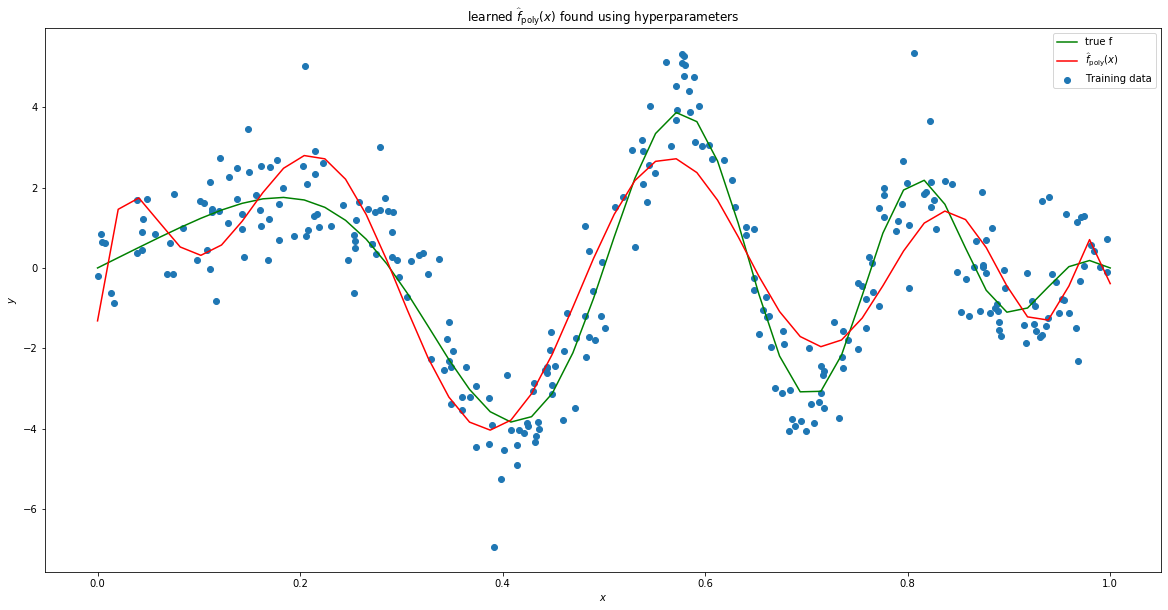

In [61]:
lam = param_poly[1]
d = param_poly[2]
K = (np.outer(X, X) + 1) ** d
alpha_poly = np.linalg.solve(K + lam*np.eye(K.shape[0]), Y)
y_hat = np.matmul((1 + np.outer(x_plot, X))**d, alpha_poly)

plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y_plot, 'g', label='true f')
plt.plot(x_plot, y_hat, 'r', label='$\widehat{f}_\mathrm{poly}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('learned $\widehat{f}_\mathrm{poly}(x)$ found using hyperparameters')
plt.legend()

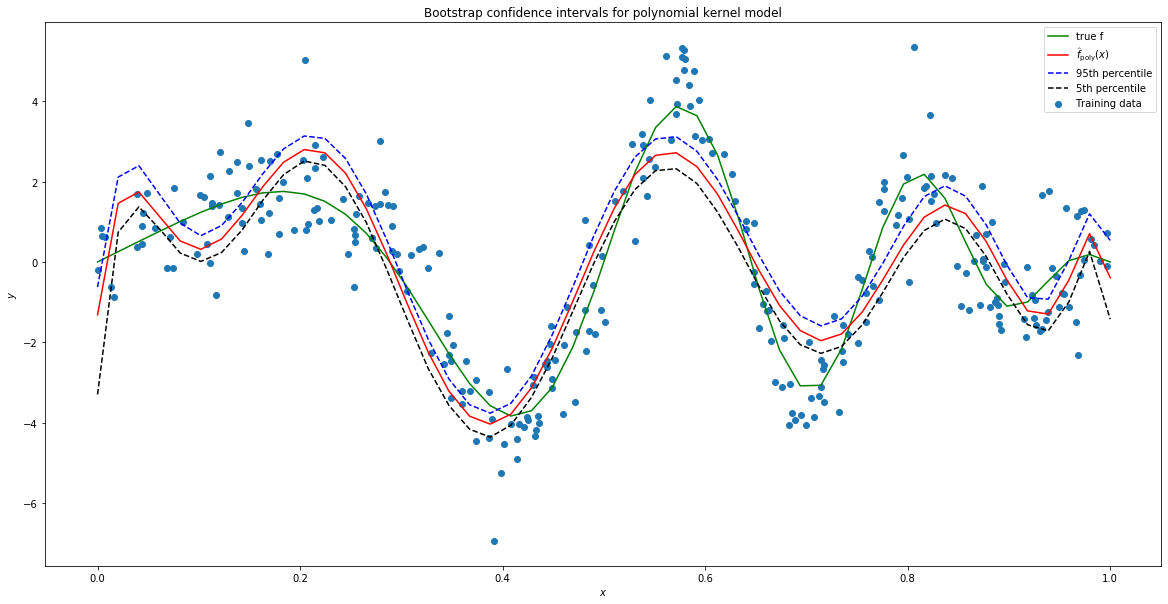

In [62]:
B = 300
predictions = np.zeros((300, len(x_plot)))
for b in range(B):
    indices = np.random.choice(n, n, replace=True)
    training_set = []
    training_y = []
    for i in range(n):
        training_set.append(X[indices[i]])
        training_y.append(Y[indices[i]])
        
    lam = param_poly[1]
    d = param_poly[2]
    K = (np.outer(training_set, training_set) + 1) ** d
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), training_y)
    y_plot_boot = np.matmul((1 + np.outer(x_plot, training_set))**d, alpha)
    
    predictions[b] = y_plot_boot
    
sort_predict = np.zeros((300, len(x_plot)))
percentile_95 = np.zeros(len(x_plot))
percentile_5 = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    sort_predict = np.sort(predictions[:, i])
    percentile_95[i] = sort_predict[int(B*0.95)]
    percentile_5[i] = sort_predict[int(B*0.05)]
    
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y_plot, 'g', label='true f')
plt.plot(x_plot, y_hat, 'r', label='$\widehat{f}_\mathrm{poly}(x)$')
plt.plot(x_plot, percentile_95, 'b--', label='95th percentile')
plt.plot(x_plot, percentile_5, 'k--', label='5th percentile')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Bootstrap confidence intervals for polynomial kernel model'.format(param_poly[1]))
plt.legend()

In [63]:
# 10 fold CV-rbf
def build_K(X):
    n = len(X)
    K = np.zeros((n, n))
    for i,a in enumerate(X):
        for j,b in enumerate(X):
            K[i,j] = (np.linalg.norm(a-b)**2)
    return K

def CV_rbf(lam, g, dist_matrix):
    total_error = 0
    folds = 10
    num_in_fold = int(n/folds)
    for fold in range(folds):
        start = fold * num_in_fold
        end = start + num_in_fold
        indices = start + np.arange(num_in_fold)
        x_validation = X[start:end]
        y_validation = Y[start:end]
        x_train = np.delete(X, np.arange(start, end))
        y_train = np.delete(Y, np.arange(start, end))
        
        K = np.delete(dist_matrix, indices, axis=1)
        K = np.exp(-g * K)
        K_valid = K[indices]
        K = np.delete(K, indices, axis=0)
        
        alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), y_train)
        predicted = K_valid.dot(alpha)
       
        error = np.sum((y_validation - predicted)**2)/len(x_validation)
        total_error += error
        
    # error
    error = total_error/folds
    return error
        

param_rbf = None
g_range = np.logspace(-3, 3, 50)
for lam in lam_range:
    dist_matrix = build_K(X)
    for g in g_range:
        error = CV_rbf(lam, g, dist_matrix)
        if param_rbf is None or error < param_rbf[0]:
            param_rbf = (error, lam, g)
print("Rbf:", param_rbf)

Rbf: (0.8843346682238369, 0.1, 104.81131341546852)


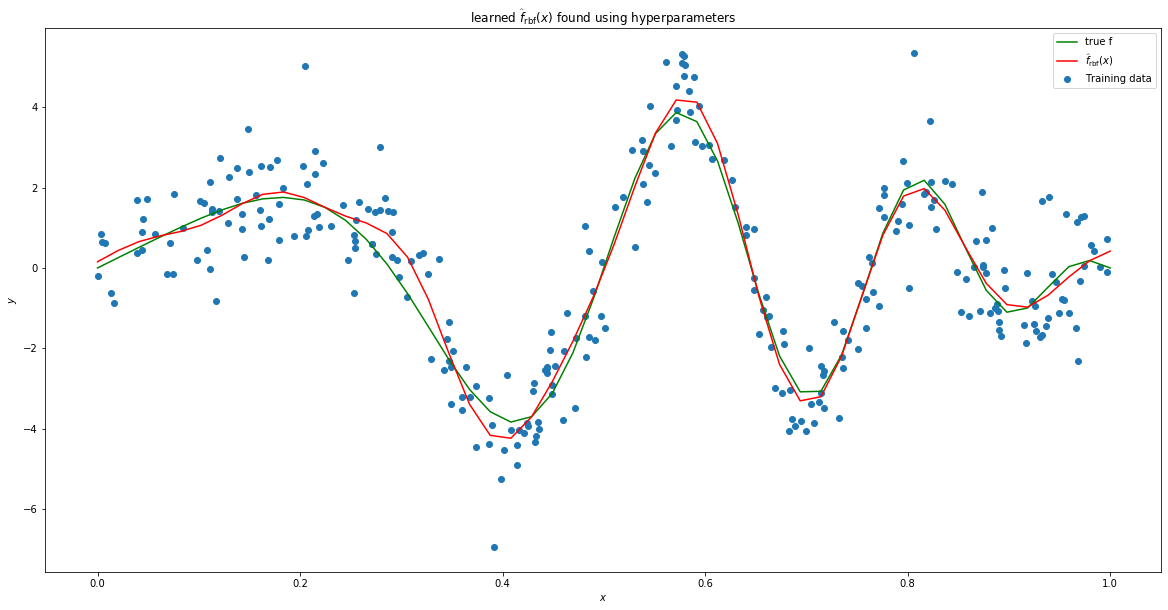

In [64]:
lam = param_rbf[1]
g = param_rbf[2]
K = build_K(X)
K = np.exp(-g * K)
alpha_rbf = np.linalg.solve(K + lam*np.eye(K.shape[0]), Y)
y_rbf = np.zeros(len(x_plot))
for i in range(len(alpha_rbf)):
    for j in range(len(x_plot)):
        y_rbf[j] += alpha_rbf[i] * np.exp(-g*np.linalg.norm(x_plot[j]-X[i])**2)
        
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y_plot, 'g', label='true f')
plt.plot(x_plot, y_rbf, 'r', label='$\widehat{f}_\mathrm{rbf}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('learned $\widehat{f}_\mathrm{rbf}(x)$ found using hyperparameters')
plt.legend()

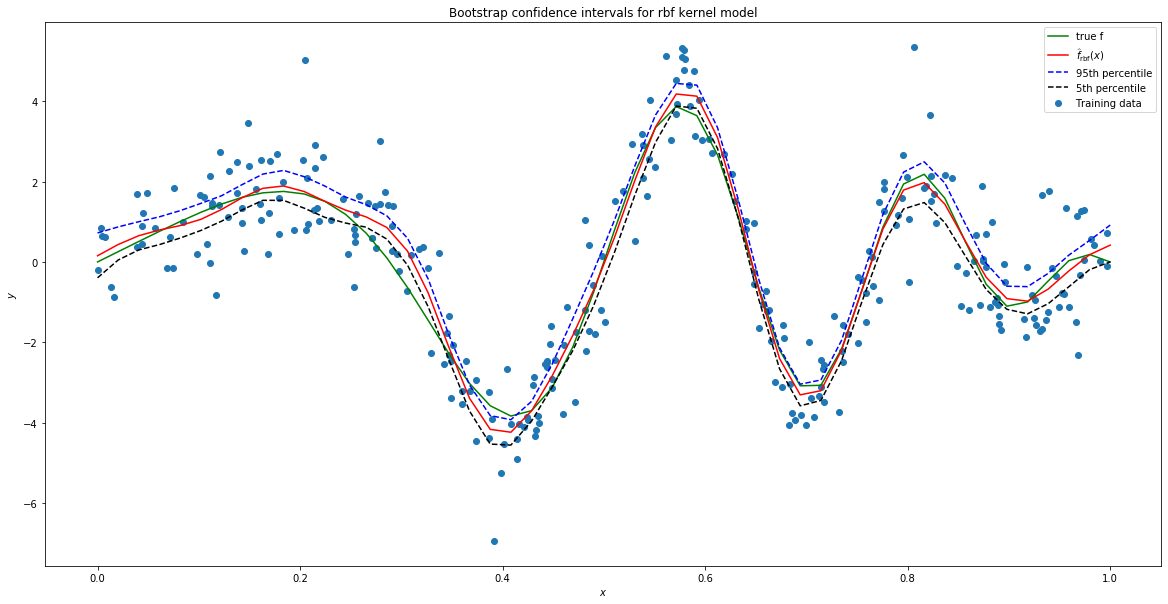

In [65]:
# rbf kernel bootstrap
B = 300
predictions = np.zeros((300, len(x_plot)))
for b in range(B):
    indices = np.random.choice(n, n, replace=True)
    training_set = []
    training_y = []
    for i in range(n):
        training_set.append(X[indices[i]])
        training_y.append(Y[indices[i]])
    
    lam = param_rbf[1]
    g = param_rbf[2]
    K = build_K(training_set)
    K = np.exp(-g * K)
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), training_y)
    y_rbf_boot = np.zeros(len(x_plot))
    for i in range(len(alpha)):
        for j in range(len(x_plot)):
            y_rbf_boot[j] += alpha[i] * np.exp(-g*np.linalg.norm(x_plot[j]-training_set[i])**2)   
    predictions[b] = y_rbf_boot
        
sort_predict = np.zeros((300, len(x_plot)))
percentile_95 = np.zeros(len(x_plot))
percentile_5 = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    sort_predict = np.sort(predictions[:, i])
    percentile_95[i] = sort_predict[int(B*0.95)]
    percentile_5[i] = sort_predict[int(B*0.05)]
    
plt.figure(figsize=(20,10))
plt.scatter(X, Y, label='Training data')
plt.plot(x_plot, y_plot, 'g', label='true f') # true f
plt.plot(x_plot, y_rbf, 'r', label='$\widehat{f}_\mathrm{rbf}(x)$')
plt.plot(x_plot, percentile_95, 'b--', label='95th percentile')
plt.plot(x_plot, percentile_5, 'k--', label='5th percentile')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Bootstrap confidence intervals for rbf kernel model'.format(param_rbf[1]))
plt.legend()

In [66]:
# A3e

# Generate Data
n = 1000
x = np.random.uniform(0, 1, n)
epsilon = np.random.normal(0, 1, n)
x_plot = np.linspace(0, 1)
y_plot = np.zeros(len(x_plot))
Y = np.zeros(n)
for i in range(n):
    Y[i] = 4 * np.sin(np.pi * x[i]) * np.cos(6 * np.pi * x[i]**2) + epsilon[i]
for i in range(len(x_plot)):
    y_plot[i] = 4 * np.sin(np.pi * x_plot[i]) * np.cos(6 * np.pi * x_plot[i]**2)

In [67]:
# bootstrap
B = 300
bootstrap = np.zeros(B)
for b in range(B):
    indices = np.random.choice(n, n, replace=True)
    training_set = []
    training_y = []
    for i in range(n):
        training_set.append(x[indices[i]])
        training_y.append(Y[indices[i]])
    # poly   
    lam = param_poly[1]
    d = param_poly[2]
    poly = np.matmul((1 + np.outer(training_set, X))**d, alpha_poly)
    # rbf
    lam = param_rbf[1]
    g = param_rbf[2]
    K = np.zeros((n, len(X)))
    for i,a in enumerate(training_set):
        for j,q in enumerate(X):
            K[i, j] = np.exp(-g*(np.linalg.norm(a-q)**2))
    rbf = K.dot(alpha_rbf)
    bootstrap[b] = np.mean((training_y - poly)**2 - (training_y - rbf)**2)
    
sorted_bootstrap = np.sort(bootstrap)
print('5th percentile: ', sorted_bootstrap[int(B*0.05)])
print('95th percentile: ', sorted_bootstrap[int(B*0.95)])

5th percentile:  0.613167994797119
95th percentile:  0.8013939878420356
